<a href="https://colab.research.google.com/github/irakliskhirtladze/Ka-OCR/blob/main/ml_training/trocr-fine-tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import re
import pandas as pd
from transformers import TrOCRProcessor
from torch.utils.data import Dataset
from PIL import Image
from transformers import VisionEncoderDecoderModel
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import random
import numpy as np
import shutil
from torch.optim import AdamW
import torch
import gc

In [2]:
def check_env() -> str:
    if 'google.colab' in str(get_ipython()):
        print("Running on Google olab")
        return "colab"

    print("Running locally")
    return "local"


if check_env() == "colab":
    # install necessary stuff for model training for colab session
    !pip install evaluate jiwer

    from evaluate import load
    from google.colab import drive
    drive.mount('/content/drive')

    # Setup paths for colab session
    data_dir = Path("/content/data")  # Dont make this dir yet, check first if it exists

    checkpoint_dir = Path("/content/checkpoints")
    checkpoint_dir.mkdir(parents=True, exist_ok=True)

    output_dir = Path("/content/output")
    output_dir.mkdir(parents=True, exist_ok=True)

    # drive storage paths
    drive_zip_path = Path("/content/drive/MyDrive/Colab Notebooks/trocr-ka/data/ka-ocr.zip")  # File

    drive_checkpoint_dir = Path("/content/drive/MyDrive/Colab Notebooks/trocr-ka/checkpoints")
    drive_checkpoint_dir.mkdir(parents=True, exist_ok=True)

    drive_output_dir = Path("/content/drive/MyDrive/Colab Notebooks/trocr-ka/output")
    drive_output_dir.mkdir(parents=True, exist_ok=True)

    if not data_dir.exists():
        print("\nExtracting dataset zip from Drive to session storage...")
        # -q means "quiet", don't print filenames. -d specifies the destination dir
        !unzip -q "{drive_zip_path}" -d "{data_dir}"
        print("Done!")
    else:
        print("Dataset already copied")

else:
    from evaluate import load

    BASE_DIR = Path(".")
    data_dir = BASE_DIR / "data"
    data_dir.mkdir(parents=True, exist_ok=True)

    checkpoint_dir = BASE_DIR / "checkpoints"
    checkpoint_dir.mkdir(parents=True, exist_ok=True)

    output_dir = BASE_DIR / "output"
    output_dir.mkdir(parents=True, exist_ok=True)


Running on Google olab
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 38.7 MB/s eta 0:00:00
Mounted at /content/drive

Extracting dataset zip from Drive to session storage...
Done!


Handle case when code is running in google colab.

In [3]:
print(f"\nDataset contents in {data_dir}:")
for item in data_dir.iterdir():
    print(f"{item.name}")


Dataset contents in /content/data:
bpg_glaho_2008
arial_geo-bold
bpg_nino_elite_ultra
bpg_ingiri_2008
bpg_glaho_traditional
bpg_extrasquare_mtavruli_2009
arial_geo-bold-italic
bpg_quadrosquare_2009
gugeshashvili_slfn_2
literaturulitt
mg_bitneon_chaos
NotoSansGeorgian
bpg_glaho_bold
bpg_boxo
metadata.csv
bpg_excelsior_caps_dejavu_2010
bpg_sans_2008
ka_lortkipanidze
bpg_paata_cond_caps
alkroundednusx-medium
bpg_phone_sans_bold_italic
mg_bitneon
gf_aisi_nus-bold-italic
version.txt
bpg_phone_sans_bold
bpg_paata_caps
ka_literaturuli
bpg_algeti
mg_niniko
3d_unicode
fixedsys_excelsior
bpg_no9
bpg_supersquare_2009
bpg_glaho_arial
bpg_boxo-boxo
bpg_phone_sans_italic
bpg_paata_exp
gf_aisi_nus_medium-medium-italic
arial_geo
bpg_rioni_contrast
bpg_rioni
bpg_rioni_vera
bpg_extrasquare_2009
bpg_nino_mtavruli_normal
bpg_dedaena
bpg_arial_2009
bpg_venuri_2010
bpg_paata
bpg_nino_mtavruli_book
bpg_algeti_compact
bpg_paata_cond
bpg_classic_medium
bpg_square_2009
bpg_nino_medium_caps
ar-archy-regular
bpg

# Explore data

In [4]:
df = pd.read_csv(data_dir/"metadata.csv")
print(df.head())
print(df.tail())

                        file_name      text
0  3d_unicode/3d_unicode_0000.png        რა
1  3d_unicode/3d_unicode_0001.png  წყდებოდა
2  3d_unicode/3d_unicode_0002.png   ჭჯნწფუქ
3  3d_unicode/3d_unicode_0003.png    წმინდა
4  3d_unicode/3d_unicode_0004.png     ჯილდო
                                         file_name         text
100495  NotoSansGeorgian/NotoSansGeorgian_1495.png     ხთვჰჟშხშ
100496  NotoSansGeorgian/NotoSansGeorgian_1496.png       რომლის
100497  NotoSansGeorgian/NotoSansGeorgian_1497.png  შემორჩენილი
100498  NotoSansGeorgian/NotoSansGeorgian_1498.png    ნეოლითური
100499  NotoSansGeorgian/NotoSansGeorgian_1499.png         უცხო


In [5]:
print(df["text"].value_counts())

text
და              4205
არ              1155
რომ             1044
იყო              785
კი               612
                ... 
ფოდჩ               1
ვჯნც               1
ტემპი              1
ჰიბიწნჟცჭჟქი       1
ჯპჭოჯგ             1
Name: count, Length: 37994, dtype: int64


In [6]:
# Check text length variations
df["text_len"] = df["text"].str.len()
print(df["text_len"].describe())

count    100500.000000
mean          6.396020
std           2.979581
min           2.000000
25%           4.000000
50%           6.000000
75%           8.000000
max          30.000000
Name: text_len, dtype: float64


# Prepare dataset and tokenizer

Checking if trocr already support tokenization for Georgian

In [7]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")

# Test Georgian tokenization
test_text = "გამარჯობა"
tokens = processor.tokenizer.tokenize(test_text)
print(tokens)  # If you see lots of <unk> or weird splits, you need a custom tokenizer

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

['á', 'ĥ', 'Ĵ', 'á', 'ĥ', 'Ĳ', 'á', 'ĥ', 'Ľ', 'á', 'ĥ', 'Ĳ', 'á', 'ĥ', 'ł', 'á', 'ĥ', '¯', 'á', 'ĥ', 'Ŀ', 'á', 'ĥ', 'ĳ', 'á', 'ĥ', 'Ĳ']


That's not what we need, so we'll create custom, character-based tokenizer.

The model predicts next token, in this case token represents char, not a word.

In [8]:
class GeorgianTokenizer:
    def __init__(self, max_length: int = 32):
        # Special tokens
        self.pad_token = "<pad>"
        self.bos_token = "<s>"      # beginning of sequence
        self.eos_token = "</s>"     # end of sequence
        self.unk_token = "<unk>"    # unknown character

        # Georgian alphabet (33 letters)
        self.georgian_chars = "აბგდევზთიკლმნოპჟრსტუფქღყშჩცძწჭხჯჰ"

        # Build vocabulary: special tokens + Georgian characters
        self.vocab = [self.pad_token, self.bos_token, self.eos_token, self.unk_token]
        self.vocab.extend(list(self.georgian_chars))

        # Create mappings
        self.char_to_id = {char: idx for idx, char in enumerate(self.vocab)}
        self.id_to_char = {idx: char for idx, char in enumerate(self.vocab)}

        # Token IDs for special tokens
        self.pad_token_id = 0
        self.bos_token_id = 1
        self.eos_token_id = 2
        self.unk_token_id = 3

        self.max_length = max_length

    def encode(self, text: str, padding: bool = True) -> list[int]:
        """Convert Georgian text to token IDs."""
        # Start with BOS token
        ids = [self.bos_token_id]

        # Convert each character
        for char in text:
            ids.append(self.char_to_id.get(char, self.unk_token_id))

        # Add EOS token
        ids.append(self.eos_token_id)

        # Truncate if too long
        if len(ids) > self.max_length:
            ids = ids[:self.max_length - 1] + [self.eos_token_id]

        # Pad if needed
        if padding:
            ids.extend([self.pad_token_id] * (self.max_length - len(ids)))

        return ids

    def decode(self, ids: list[int]) -> str:
        """Convert token IDs back to text."""
        chars = []
        for id in ids:
            if id in (self.pad_token_id, self.bos_token_id, self.eos_token_id):
                continue
            chars.append(self.id_to_char.get(id, ""))
        return "".join(chars)

    def __len__(self):
        return len(self.vocab)

Test tokenization again

In [9]:
tokenizer = GeorgianTokenizer(max_length=32)

# Test encoding
text = "გამარჯობა"
ids = tokenizer.encode(text)
print(f"Text: {text}")
print(f"IDs: {ids[:15]}...")  # First 15 tokens
print(f"Length: {len(ids)}")

# Test decoding
decoded = tokenizer.decode(ids)
print(f"Decoded: {decoded}")

# Verify vocab size
print(f"Vocab size: {len(tokenizer)}")  # Should be 37 (4 special + 33 Georgian)

Text: გამარჯობა
IDs: [1, 6, 4, 15, 4, 20, 35, 17, 5, 4, 2, 0, 0, 0, 0]...
Length: 32
Decoded: გამარჯობა
Vocab size: 37


Works as expected.

Now we prepare dataset using this tokenizer

In [10]:
class GeorgianOCRDataset(Dataset):
    def __init__(self, df: pd.DataFrame, root_dir: str, processor, tokenizer: GeorgianTokenizer):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.processor = processor
        self.tokenizer = tokenizer  # custom tokenizer

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> dict[str, torch.Tensor]:
        text = self.df.iloc[idx]['text']
        file_path = f"{self.root_dir}/{self.df.iloc[idx]['file_name']}"

        # Open and process image
        img = Image.open(file_path).convert("RGB")
        w, h = img.size
        target_size = 384

        # Scale height to target_size, width proportionally
        scale = target_size / max(w, h)
        new_w, new_h = int(w * scale), int(h * scale)
        img = img.resize((new_w, new_h), Image.Resampling.BILINEAR)

        # Pad to square
        new_img = Image.new("RGB", (target_size, target_size), (255, 255, 255))
        offset = ((target_size - new_w) // 2, (target_size - new_h) // 2)
        new_img.paste(img, offset)

        # Use Processor for Normalization
        pixel_values = self.processor(new_img, return_tensors="pt").pixel_values

        # Tokenize Georgian Text
        labels = self.tokenizer.encode(text)

        # Replace padding token id with -100 so it's ignored by the loss function
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]

        return {
            "pixel_values": pixel_values.squeeze(),
            "labels": torch.tensor(labels)
        }

Prepare model...

we give it our 37 tokens so model predicts only 37 possible outputs instead of original 50k.

In [11]:
# Create your tokenizer
tokenizer = GeorgianTokeasdnizer(max_length=32)

# Load model and resize token embeddings
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")
model.decoder.resize_token_embeddings(len(tokenizer))  # Resize to 37

# Configure special tokens
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.eos_token_id

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Train test split

In [12]:
train_df, test_df = train_test_split(
    df,
    test_size=0.10,
    random_state=42,
    shuffle=True
)

print(train_df["text"].value_counts())

text
და          3803
არ          1044
რომ          947
იყო          705
კი           546
            ... 
იტალიური       1
ქუჩისა         1
შთოკ           1
ღხომკტცა       1
შმოი           1
Name: count, Length: 35172, dtype: int64


In [13]:
train_dataset = GeorgianOCRDataset(train_df, data_dir, processor, tokenizer)
test_dataset = GeorgianOCRDataset(test_df, data_dir, processor, tokenizer)

loader_generator = torch.Generator()
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, generator=loader_generator, num_workers=2 if check_env() == "colab" else 8)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

Running on Google olab
Train batches: 5654, Test batches: 629


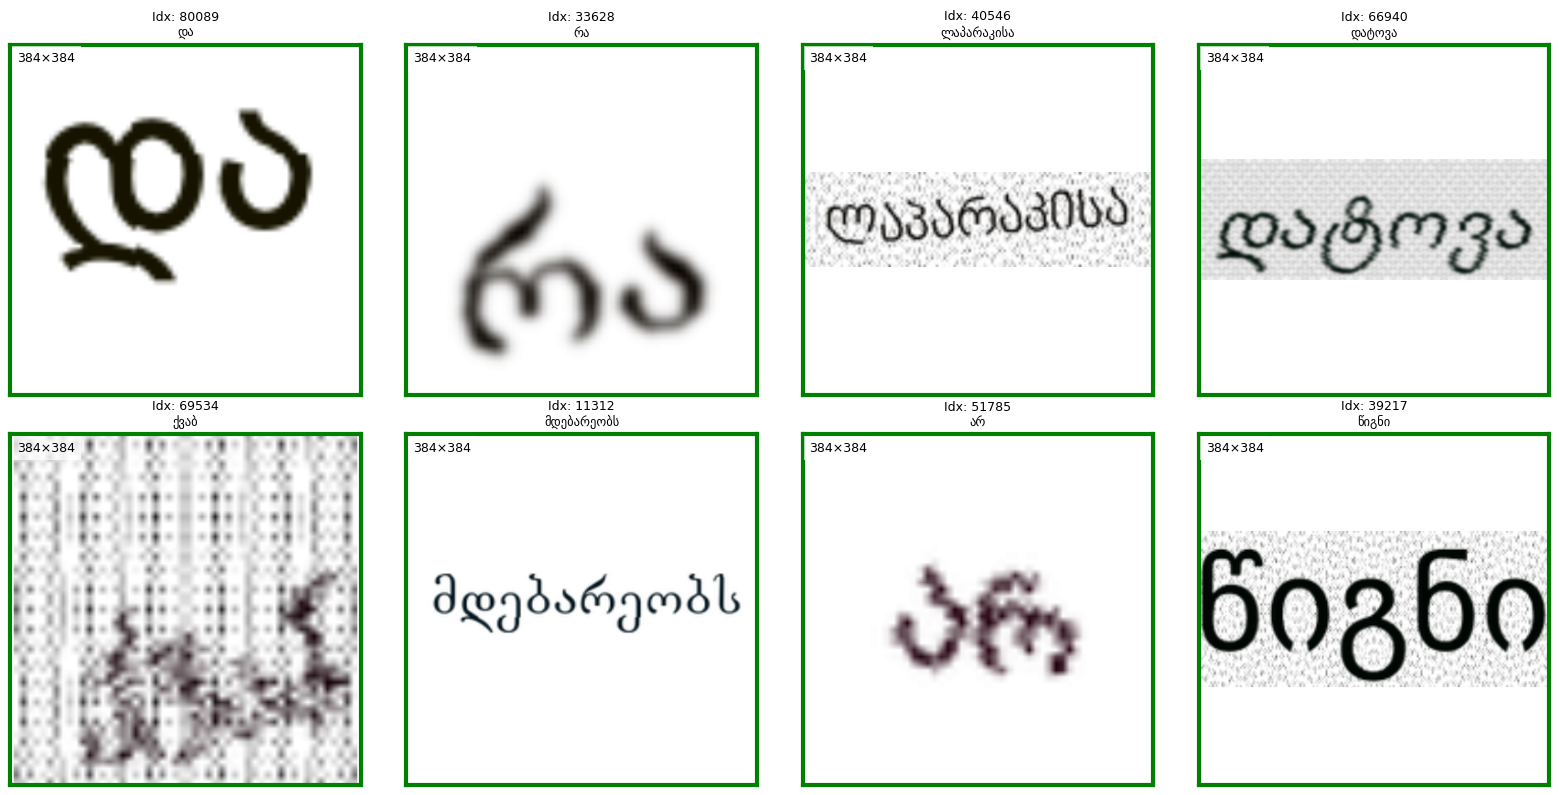

In [23]:
# ### To check if images are correctly processed by GeorgianOCRDataset
# def visualize_processed_samples(dataset, num_samples: int, border_color: str = "green", border_width: float = 3.0):
#     # Choose indices
#     indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

#     # Layout: 4 columns looks nice for 8 images
#     ncols = 4
#     nrows = int(np.ceil(len(indices) / ncols))

#     plt.figure(figsize=(4 * ncols, 4 * nrows))

#     for i, idx in enumerate(indices):
#         sample = dataset[idx]
#         pixel_values = sample["pixel_values"]
#         labels = sample["labels"]

#         # (C,H,W) -> (H,W,C)
#         img = pixel_values.permute(1, 2, 0).detach().cpu().numpy()

#         # Normalize safely for display
#         img_min, img_max = img.min(), img.max()
#         if img_max > img_min:
#             img = (img - img_min) / (img_max - img_min)

#         # Decode labels (works with your custom tokenizer)
#         clean_labels = [l if l != -100 else dataset.tokenizer.pad_token_id for l in labels.tolist()]
#         decoded_text = dataset.tokenizer.decode(clean_labels)

#         ax = plt.subplot(nrows, ncols, i + 1)
#         ax.imshow(img)
#         ax.set_title(f"Idx: {idx}\n{decoded_text}", fontsize=9)
#         ax.set_xticks([])
#         ax.set_yticks([])

#         # Make the axes box square (visual check)
#         ax.set_box_aspect(1)

#         # Green border
#         for spine in ax.spines.values():
#             spine.set_visible(True)
#             spine.set_edgecolor(border_color)
#             spine.set_linewidth(border_width)

#         # Optional: also print actual tensor shape on the image for certainty
#         h, w = img.shape[:2]
#         ax.text(
#             0.02, 0.98, f"{h}×{w}",
#             transform=ax.transAxes,
#             va="top", ha="left",
#             fontsize=9,
#             bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
#         )

#     plt.tight_layout()
#     plt.show()


# # Run the visualization (replace 'train_dataset' with your variable name)
# visualize_processed_samples(train_dataset, num_samples=8)

# Dataloaders

# Set up training

# Validation function

In [16]:
# Load the CER metric (standard for OCR)
cer_metric = load("cer")

def validate_model(
    model: torch.nn.Module,
    val_loader: torch.utils.data.DataLoader,
    tokenizer: GeorgianTokenizer,
    device: torch.device
) -> float:

    model.eval()
    predictions: list[str] = []
    references: list[str] = []

    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # Generate text from image
            outputs = model.generate(pixel_values)

            # Convert tokens back to strings
            pred_str = [tokenizer.decode(ids.tolist()) for ids in outputs]

            # Convert label tokens back to strings (ignoring -100 padding)
            labels[labels == -100] = tokenizer.pad_token_id
            label_str = [tokenizer.decode(ids.tolist()) for ids in labels]

            predictions.extend(pred_str)
            references.extend(label_str)

    # Calculate Character Error Rate
    return cer_metric.compute(predictions=predictions, references=references)

# Training loop

In [17]:
def save_state(epoch: int,
               batch_idx: int,
               model: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scaler: torch.cuda.amp.GradScaler,
               loss: float,
               filename: str,
               generator: torch.Generator):

    """Saves weights and the exact generator state to preserve shuffle order."""
    checkpoint = {
        'epoch': epoch,
        'batch_idx': batch_idx,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'loss': loss,
        'rng_state_torch': torch.get_rng_state(),
        'rng_state_numpy': np.random.get_state(),
        'rng_state_python': random.getstate(),
        'dataloader_generator_state': generator.get_state(),
    }

    # Ensure directories exist
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    if check_env() == "colab":
        drive_checkpoint_dir.mkdir(parents=True, exist_ok=True)

    # Save locally first
    local_path = checkpoint_dir / filename
    torch.save(checkpoint, local_path)

    # Atomic sync to Drive (only on Colab)
    if check_env() == "colab":
        drive_path = drive_checkpoint_dir / filename
        temp = drive_path.with_suffix(drive_path.suffix + ".tmp")
        shutil.copy(local_path, temp)
        os.replace(temp, drive_path)
        print(f"Checkpoint synced to Drive: {filename}")
    else:
        print(f"Checkpoint saved locally: {filename}")

    # Delete all other checkpoint files
    for chpt in checkpoint_dir.glob("*.pt"):
        if chpt.name != filename:
            chpt.unlink()
            print(f"Deleted old checkpoint: {chpt.name}")
    if check_env() == "colab":
        for chpt in drive_checkpoint_dir.glob("*.pt"):
            if chpt.name != filename:
                chpt.unlink()
                print(f"Deleted old checkpoint on Drive: {chpt.name}")


def load_latest_state(model: torch.nn.Module,
                      optimizer: torch.optim.Optimizer,
                      scaler: torch.cuda.amp.GradScaler,
                      generator: torch.Generator,
                      load_optimizer: bool = True,
                      load_scaler: bool = True) -> tuple[int, int]:
    """Finds the latest .pt file and restores model + (optionally) optimizer/scaler + RNG state."""

    search_path = checkpoint_dir
    if check_env() == "colab":
        search_path = drive_checkpoint_dir

    checkpoints = [p for p in search_path.glob("*.pt") if not p.name.endswith(".tmp")]
    if not checkpoints:
        print("No checkpoints found. Starting from scratch.")
        return 0, -1

    _ckpt_re = re.compile(r"^checkpoint_e(\d+)_b(\d+)\.pt$")

    def parse_ckpt_key(p: Path) -> tuple[int, int]:
        m = _ckpt_re.match(p.name)
        if not m:
            return -1, -1
        return int(m.group(1)), int(m.group(2))

    sorted_ckpts = sorted(checkpoints, key=parse_ckpt_key, reverse=True)

    for ckpt_path in sorted_ckpts:
        try:
            print(f"Attempting to load: {ckpt_path.name}")
            ckpt = torch.load(ckpt_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')

            model.load_state_dict(ckpt['model_state_dict'])

            if load_optimizer and 'optimizer_state_dict' in ckpt:
                optimizer.load_state_dict(ckpt['optimizer_state_dict'])

            if load_scaler and 'scaler_state_dict' in ckpt:
                scaler.load_state_dict(ckpt['scaler_state_dict'])

            # Restore RNG states so DataLoader continues same shuffle
            if 'rng_state_torch' in ckpt:
                torch.set_rng_state(ckpt['rng_state_torch'])
            if 'rng_state_numpy' in ckpt:
                np.random.set_state(ckpt['rng_state_numpy'])
            if 'rng_state_python' in ckpt:
                random.setstate(ckpt['rng_state_python'])
            if 'dataloader_generator_state' in ckpt:
                generator.set_state(ckpt['dataloader_generator_state'])

            print(f"Resumed from: {ckpt_path.name}")
            return ckpt.get('epoch', 0), ckpt.get('batch_idx', -1)

        except Exception as e:
            print(f"Failed to load {ckpt_path.name}: {e}. Trying next...")
            continue

    print("All checkpoints failed to load. Starting from scratch.")
    return 0, -1


In [18]:
def train_model(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    epochs: int = 3,
    save_every: int = 1000,
    max_grad_norm: float = 1.0,
    resume_latest: bool = True
) -> None:

    # Mixed precision scaler for faster training on GPU
    if resume_latest:
        start_epoch, start_batch = load_latest_state(model, optimizer, scaler, loader_generator)
    else:
        start_epoch, start_batch = 0, -1

    for epoch in range(start_epoch, epochs):
        model.train()
        print(f"\n--- Starting Epoch {epoch} ---")

        # Create iterator for this epoch
        train_iter = iter(train_loader)
        batch_offset = 0

        # Fast-forward past already-trained batches (only on resume epoch)
        if epoch == start_epoch and start_batch >= 0:
            skip_count = start_batch + 1
            print(f"Fast-forwarding past {skip_count} batches...")
            for _ in range(skip_count):
                try:
                    next(train_iter)
                except StopIteration:
                    break
            batch_offset = skip_count

        # Continue training from where we left off
        for batch_idx, batch in enumerate(train_iter, start=batch_offset):
            try:
                # Prepare data
                pixel_values: torch.Tensor = batch["pixel_values"].to(device)
                labels: torch.Tensor = batch["labels"].to(device)

                # Forward pass with automatic mixed precision
                with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
                    outputs = model(pixel_values=pixel_values, labels=labels)
                    loss: torch.Tensor = outputs.loss

                # Backward pass with gradient scaling
                scaler.scale(loss).backward()

                # Gradient clipping (unscale first, then clip)
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

                # Optimizer step with scaler
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

                # Logging
                if batch_idx % 100 == 0:
                    print(f"Epoch: {epoch} | Batch: {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}")

                # Checkpointing Logic
                if batch_idx > 0 and batch_idx % save_every == 0:
                    checkpoint_name: str = f"checkpoint_e{epoch}_b{batch_idx}.pt"
                    save_state(epoch, batch_idx, model, optimizer, scaler, loss.item(), checkpoint_name, loader_generator)
                    print(f"===== Saved checkpoint {checkpoint_name} =====")

            except RuntimeError as e:
                # OOM Shield
                if "out of memory" in str(e).lower():
                    print(f"GPU OOM detected at batch {batch_idx}. Cleaning memory and skipping...")

                    # Manually clear all variables that could be holding GPU references
                    if 'outputs' in locals(): del outputs
                    if 'loss' in locals(): del loss
                    del pixel_values, labels

                    optimizer.zero_grad(set_to_none=True)
                    gc.collect()
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e

        # End of epoch: save checkpoint and validate
        checkpoint_name = f"checkpoint_e{epoch}_b{len(train_loader) - 1}.pt"
        save_state(epoch, len(train_loader) - 1, model, optimizer, scaler, loss.item(), checkpoint_name, loader_generator)

        print(f"Running Validation for Epoch {epoch}...")
        current_cer: float = validate_model(model, test_loader, tokenizer, device)

        print(f"Epoch {epoch} Results:")
        print(f"   Character Error Rate (CER): {current_cer:.4f}")
        print(f"   (Translation: {100 - (current_cer*100):.2f}% character accuracy)")

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Training on {device}")

# 1) Create a "dummy" optimizer/scaler just to satisfy the loader signature
dummy_optimizer = AdamW(model.parameters(), lr=1e-5)
dummy_scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

# 2) Load checkpoint but DO NOT load optimizer/scaler state (safe resume)
ckpt_epoch, ckpt_batch = load_latest_state(
    model,
    dummy_optimizer,
    dummy_scaler,
    loader_generator,
    load_optimizer=False,
    load_scaler=False
)

# 3) Now create a fresh optimizer with a LOWER LR (this is the key change)
optimizer = AdamW(model.parameters(), lr=1e-5)  # try 1e-5 first; if still unstable use 5e-6

# 4) Train normally, but disable auto-resume inside train_model (we already resumed safely)
train_model(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    device=device,
    epochs=EPOCHS,
    save_every=SAVE_EVERY,
    max_grad_norm=1.0,
    resume_latest=False
)


Training on: cpu


# Saving the fine-tuned model

In [ ]:
def save_final_model():
    """Save the final trained model and processor."""
    model_path = output_dir / "model"
    processor_path = output_dir / "processor"

    # Save model and processor
    model.save_pretrained(model_path)
    processor.save_pretrained(processor_path)

    # Save custom tokenizer vocab
    tokenizer_path = output_dir / "tokenizer_vocab.json"
    import json
    with open(tokenizer_path, 'w', encoding='utf-8') as f:
        json.dump({
            'char_to_id': tokenizer.char_to_id,
            'id_to_char': {str(k): v for k, v in tokenizer.id_to_char.items()},
            'pad_token_id': tokenizer.pad_token_id,
            'bos_token_id': tokenizer.bos_token_id,
            'eos_token_id': tokenizer.eos_token_id,
            'unk_token_id': tokenizer.unk_token_id,
        }, f, ensure_ascii=False, indent=2)

    print(f"Model saved to: {model_path}")
    print(f"Processor saved to: {processor_path}")
    print(f"Tokenizer vocab saved to: {tokenizer_path}")

    # Sync to Drive on Colab
    if check_env() == "colab":
        drive_output_dir.mkdir(parents=True, exist_ok=True)

        # Create a zip of the output for easy download
        zip_path = output_dir / "final_model.zip"
        shutil.make_archive(str(zip_path.with_suffix('')), 'zip', output_dir)

        # Copy zip to Drive
        shutil.copy(zip_path, drive_output_dir / "final_model.zip")
        print(f"Model zip synced to Drive: {drive_output_dir / 'final_model.zip'}")


# Run the save
save_final_model()